In [39]:
from math import exp,log
import numpy as np
from numpy import linalg as LA
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import time
import matplotlib.dates as date
from scipy.interpolate import interp1d
from submapp import map2d, som, hmm
from tools.tools_som import *
import seaborn as sns

## STEP 0: data processing

##### 0.1 Extract data from files

There is nothing to change in this cell, just run the cell to extract data from the netcdf4 file. 
If this does not work, make sure the file ``GotmFabmErsem-BATS.nc`` is in the right folder. (It should be in the same folder as this notebook, ``submapp`` folder and ``tools`` folder )

In [40]:
############ STEP 0.1 ##################################################
# ---- Extracting data
([temp_y, sst_y, dswr_y, airt_y, ws10_y ,depth]) = data_extraction()
gotm_data = [temp_y, sst_y, dswr_y, airt_y, ws10_y ,depth]
data_type = ["temp", "sst", "dswr", "airt", "ws10", "depth"]

for i in range(len(gotm_data)-1):
    for y in range(len(gotm_data[i])):
        gotm_data[i][y] = mean_steps(gotm_data[i][y],10)
[temp_y, sst_y, dswr_y, airt_y, ws10_y ,depth] = gotm_data

##### 0.2 Select data types

<span style="background-color: ##FFFF00">**TO DO**: </span>

- Select the data types you want to work with by initializing the list ``data_type_used`` with some of the following elements 
     - 0: Temperature (temp)
     - 1: Sea surface temperature (sst)
     - 2: Incoming Short Wave Radiation (dswr)
     - 3: Air Temperature (airt)
     - 4: Wind Speed (ws10)
     - (-1): Depth (depth)
     
``Temperature (0)`` is related to the vertical profiles of temperature, in our case they are the "*hidden*" values.

`` Depth (-1)`` is a vector of levels of depth corresponding to the vertical profiles

``Sea surface temperature (1), Incoming Short Wave Radiation (2), Air Temperature (3)`` and ``Wind Speed (4)`` are surface information types. in our case they are the "*observable*" values from which we want to infer *hidden* values

<span style="background-color: ##FFFF00">**NOTE**: </span>

- For *hidden* variables you should only select ``temperature`` then ``data_type_used = [0]``. 
- For *observale* variables you should, of course, choose the same ones as in the SOM phase! In our case we only used ``sst`` and ``dswr`` but feel free to play with other variables as well - but don't forget to train the SOM and create the Map2d before ! :) 

In [41]:
############ STEP 0.2 ##################################################

# ----------------------------
# TODO: 
# --- Select your data by initializing data_type_used
# - 0: Temperature (temp)
# - 1: Sea surface temperature (sst)
# - 2: Incoming Short Wave Radiation (dswr)
# - 3: Air Temperature (airt)
# - 4: Wind Speed (ws10)
# - (-1): Depth (depth)
data_type_used_obs = [1,2]  # suggested observable variables 
data_type_used_hid = [0]  # hidden variables
# ----------------------------

##### 0.2 Select the 4 Map2d 

###### 0.2.1 Reconstruct paths and filenames

You need 4 maps to train and test your HMM. 
- ``map_obs_train``
- ``map_obs_test``
- ``map_hid_train``
- ``map_hid_test``

These maps have to be created by 2 different SOM: ``som_obs`` and ``som_hid`` Their shape determines the shape of the matrices defining the HMM: ``(Tr, Em, pi)`` You should then specify both shapes in order to initialize the HMM.

In addition, if you used the defaults path and filenames while creating the maps you have only have to specify ``nb_years_trained``, ``prob_obs`` and ``prob_dis`` if you want to reconstruct all the paths and filenames of the saved objects. Otherwise you can specify their corresponding names and filenames. 

<span style="background-color: ##FFFF00">**TO DO**: </span>
- Specify the shapes of both SOM related to the observable and hidden variables ``(n_obs,m_obs)`` and ``(n_hid,m_hid)``
- Select the number of years in the training dataset ``nb_years_trained``(the same as in the SOMs)
- Specify ``prob_obs`` and ``prob_dis``, the probabilities of getting a value for each instant ``t``

<span style="background-color: ##FFFF00">**TO DO**: (Optional) </span>
- Specify manually the name and paths of the different saved objects if you did not used the defaults ones while creating them

In [42]:
############ STEP 0.2.1 ##################################################

# ----------------------------
# TODO: 
# ---- Select the shape of the Maps you want to work with
# (These maps have to be created beforehand!)
n_obs = 2  
m_obs = 70
n_hid = 4 
m_hid = 70  
# ----------------------------

# ----------------------------
# TODO: 
# ---- Select the number of years used for the training 
# (should be the same number as the one used for the SOM)
nb_years_trained = 12
# ----------------------------


# ----------------------------
# TODO: 
# ---- Select the probability of missing a vector at each instant
prob_obs = 1.
prob_hid = 1.
# ----------------------------


# ---- Retrieve the names of the data type used to reconstruct the default paths
data_name_obs = ""
for i in data_type_used_obs:
    data_name_obs = data_name_obs + data_type[i] + "-" 
data_name_obs=data_name_obs[:-1]
data_name_hid = ""
for i in data_type_used_hid:
    data_name_hid = data_name_hid + data_type[i] + "-" 
data_name_hid=data_name_hid[:-1]

# ---- Reconstruct the default paths
path_map_obs = "objects/Map/" + data_name_obs + "/"+str(n_obs)+"-"+str(m_obs)+"/" +str(int(prob_obs*100))+'/'
path_map_hid = "objects/Map/" + data_name_hid + "/"+str(n_hid)+"-"+str(m_hid)+"/"+str(int(prob_hid*100))+'/'

# ---- Reconstruct the default filenames
name_train = "1992-"+str(1992+nb_years_trained-1)+"_mapped"    
#name_test = str(1992+nb_years_trained)+"-2007_mapped"  # for complete testing dataset
name_test = "2007_mapped"  # to select only one testing year


###### 0.2.1 Load the maps 

Once all the names and filenames are initialized you can load your 4 maps! :)

In [43]:
############ STEP 0.2.2 ##################################################
# ---- Load the maps with the defaults filenames and paths
map_obs_train = map2d.load(path=path_map_obs, filename=name_train)
map_obs_test = map2d.load(path=path_map_obs, filename=name_test)
map_hid_train = map2d.load(path=path_map_hid, filename=name_train)
map_hid_test = map2d.load(path=path_map_hid, filename=name_test)

## STEP 1: HMM configuration and training

##### 1.1 Initialize Hmm object

<span style="background-color: ##FFFF00">**NOTE**: </span>

In order to better visualize and monitor the training, we will use the Hmm model to reconstruct the vertical profiles from ``map_obs_test.classes`` with the ``viterbi`` method at each step of the training. Then - at each step - we will plot the emission and transition matrices ``Em`` and ``Tr`` and the reconstructed vertical profiles.  There are many other ways to visualize and evaluate the results such as plotting the error or comparing to another model output, so do not hesitate to try other options! 

###### 1.1.1 Define paths and filenames

You need 4 maps to train and test your HMM. 
- ``map_obs_train``
- ``map_obs_test``
- ``map_hid_train``
- ``map_hid_test``

These maps have to be created by 2 different SOM: ``som_obs`` and ``som_hid`` Their shape determines the shape of the matrices defining the HMM: ``(Tr, Em, pi)`` You should then specify both shapes in order to initialize the HMM.

In addition, if you used the defaults path and filenames while creating the maps you have only have to specify ``nb_years_trained``, ``prob_obs`` and ``prob_dis`` if you want to reconstruct all the paths and filenames of the saved objects. Otherwise you can specify their corresponding names and filenames. 

<span style="background-color: ##FFFF00">**TO DO**: (Optional)</span>

- Customize the name of the Hmm ``myHMM``
- Customize the name of map estimated by the HMM ``map_hid_est``
- Customize the default relative path at which ``map_hid_est`` will be saved
- Customize the default relative path at which ``myHMM`` will be saved

In [44]:
############ STEP 1.1.1 ##################################################

# ----------------------------
# TODO: (optional)
# ---- Customize default paths and names
data_name_hmm = data_name_obs + "_" + data_name_hid
shape_hmm = str(n_obs)+"-"+str(m_obs)+"_"+str(n_hid)+"-"+str(m_hid)
path_map_est = "objects/Map/" + data_name_hmm + "/" + shape_hmm + "/" + str(int(prob_hid*100)) +'/'
path_hmm = "objects/Hmm/" + data_name_hmm + "/" + shape_hmm + "/" + str(int(prob_hid*100)) +'/'
name_est = str(1992+nb_years_trained)+"-2007_mapped_est"
name_hmm = "1992-"+str(1992+nb_years_trained-1)+"_trained"
# ----------------------------

###### 1.1.2 Initialize Hmm object and model

- The function ``hmm.Hmm`` creates the Hmm object
- The method ``init_model`` initializes the probabilities (elements of the matrices ``(Tr, Em, pi)``) by counting the transitions and emission in the training dataset
- pi is not really important and we don't have enough years in our training dataset so our prior is not informative enough. A uniform probability works well though.

 #################### INITIALIZATION ##########################
 #################### VISUALIZATION ##########################
Viterbi algorithm done in  0.06  sec, using  72  inputs


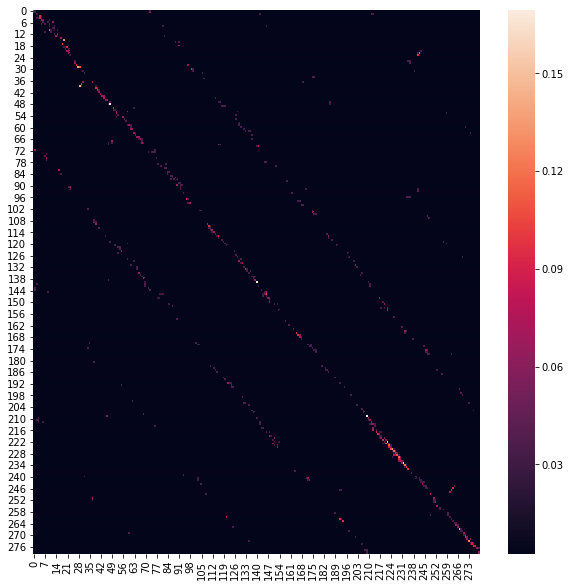

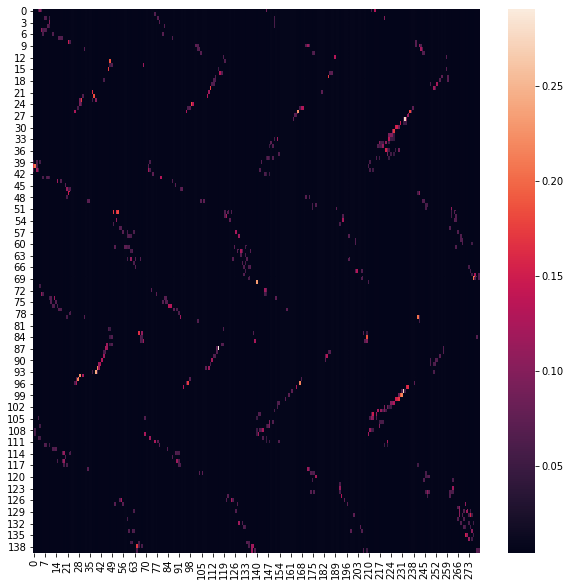

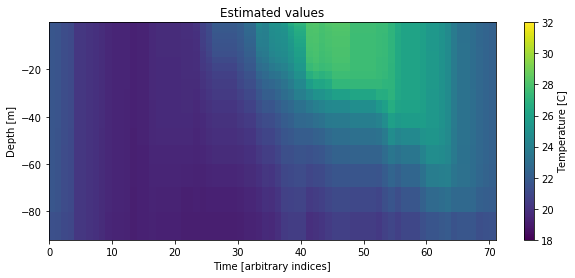

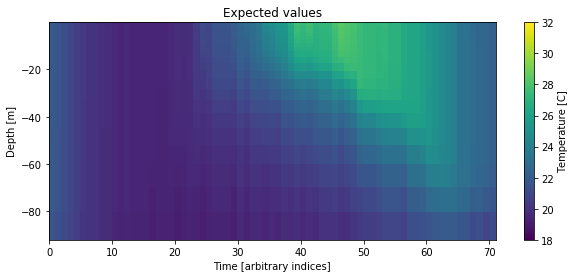

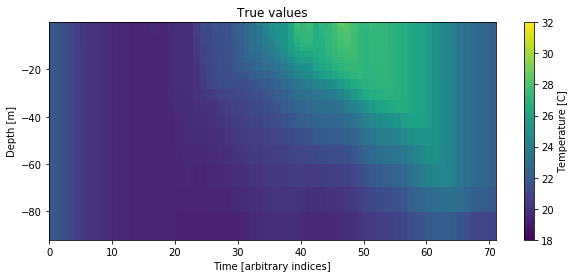

In [49]:
############ STEP 1.1.2 ##################################################

print(" #################### INITIALIZATION ##########################")
myHMM = hmm.Hmm(n_obs*m_obs,n_hid*m_hid, name=name_hmm)
myHMM.init_model(map_obs_train.classes, map_hid_train.classes)
myHMM.pi = np.ones((n_hid*m_hid))  

print(" #################### VISUALIZATION ##########################")
classes_hid_est = myHMM.viterbi(map_obs_test.classes)
map_hid_est = map2d.Map2d(som=map_hid_test.som, name=name_est)
map_hid_est.map_from_classes(classes_hid_est, true_values=map_hid_test.true_values, overwrite=True)

fig= plt.figure(figsize=(10,10))
sns.heatmap(myHMM.Tr, annot=False)
fig= plt.figure(figsize=(10,10))
sns.heatmap(myHMM.Em, annot=False)

print_data(map_hid_est.values,depth,zmin=18,zmax=32, legend="Estimated values", figsize=(10,4))
print_data(map_hid_test.values,depth,zmin=18,zmax=32, legend="Expected values", figsize=(10,4))
print_data(map_hid_est.true_values,depth,zmin=18,zmax=32, legend="True values", figsize=(10,4))

##### 1.2 Training

###### 1.2.1 Neighborhood function

As mentioned in the configuration step of the SOM, the more classes there are, the more difficult it is to estimate the model parameters of the HMM. Here, our training dataset is not large enough to provide the HMM with enough different emissions and transitions: a lot of *possible* emissions and transitions are never observed in the training dataset but they could have been and their probability should not be null. We should then find a way to increase their probability without increasing probability of physically impossible events. 

One of the main advantages of SOM is that referent vectors associated to topologically neighbouring classes will have similar properties. For instance, since we are working with time series referent vectors that are close to each other in the map represent the same period of the year and share common features. 

Then in our case, the number of classes in higher in ``som_hid`` than in ``som_obs`` because the vertical profiles are more complex than surface data. Thus the PROFHMM method suggests, we use a neighboring function that exploits the topological properties of the SOM to “propagate” the probability of a hidden class to its neighbors.

$$
     Tr(i,j) = S_{Tr}^{-1}\sum_{k=1}^{N_{\rm dis}} exp(-\frac{dist(j,k)}{\sigma}) Tr(i,k) 
$$

$$
    Em(i,j) = S_{Em}^{-1}\sum_{k=1}^{N_{\rm dis}} exp(-\frac{dist(j,k)}{\sigma}) Em(i,k) 
$$

with $S_{Tr}^{-1}$ and $S_{Em}^{-1}$ normalizing factors such as $\sum_{j=1}^{N_{dis}} Tr(i,j)= \sum_{i=1}^{N_{obs}} Em(i,j) = 1$

Now we have to choose $\sigma$ - the typical distance to which the probabilities should be spread.

- if $\sigma$ too is small, the new probabilities will be very close to the original 

- if $\sigma$ is too large, the new probabilities will not be almost uniform throughout the hidden map.

This typical distance is strongly linked to the nature of the data used and the shape of the SOM, thus using the same radius regardless of the data and the SOM used could be irrelevant. Instead we can compute $\sigma$ according to the actual typical distance covered by each transition that occurred while training the SOM ``som_hid``

In our case we use the mean of the distance covered by transition during the training of ``som_hid`` after removing outliers (are regarded as outliers distance that are superier

<span style="background-color: ##FFFF00">**TO DO**: (Optional)</span>
- Change the value of ``outlier_threshold`` and observe the results! :) 
- Change the value of ``sigma`` and observe the results! :) 

------------------------------------------------
#################### SUMMARY ###################
------------------------------------------------
MEAN DISTANCE OF TRANSITIONS: 2.0442629666124046
STDEV DISTANCE OF TRANSITIONS: 
THRESHOLD USED:  0.9
DISTANCE MAX TRAVELLED BY  90.0 % OF TRANSITIONS  4.0
MEAN DISTANCE OF TRANSITIONS AFTER REMOVING OUTLIERS:  1.217498444595147
STDEV DISTANCE OF TRANSITIONS AFTER REMOVING OUTLIERS:  0.9650033015460955
SIGMA USED:  1.217498444595147
 #################### NEIGHBORHOOD ##########################
 #################### VISUALIZATION ##########################
Viterbi algorithm done in  0.04  sec, using  72  inputs


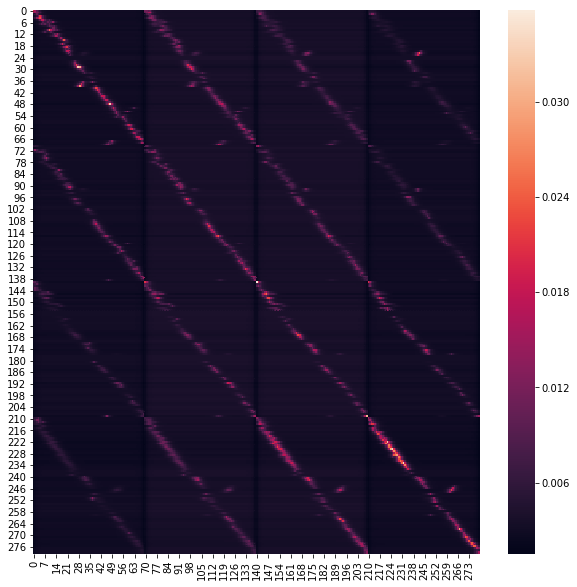

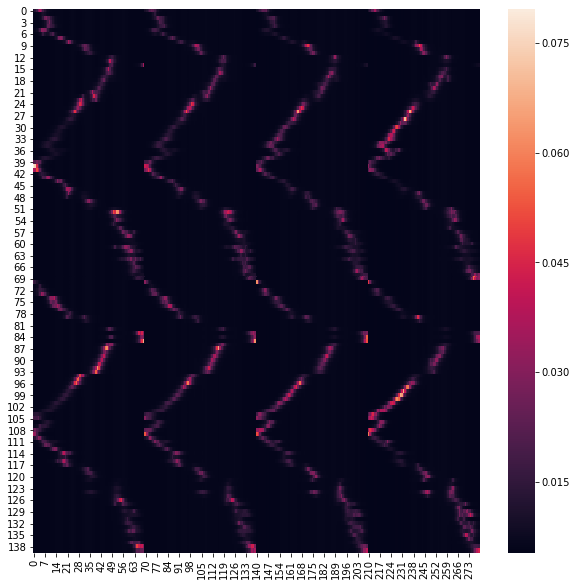

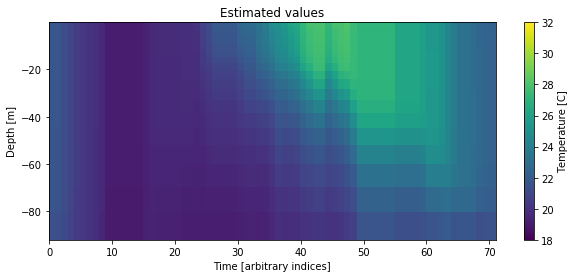

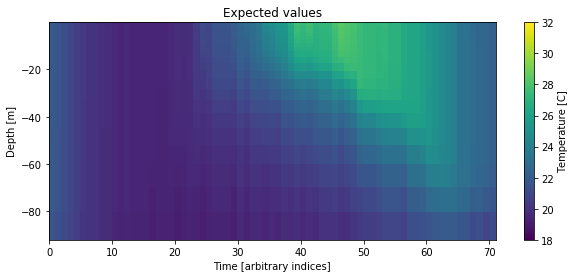

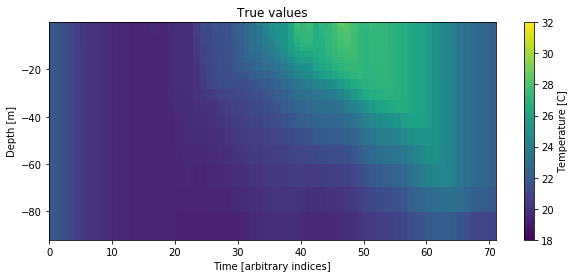

In [54]:
############ STEP 1.2.1 ##################################################

# ----------------------------
# TODO: (optional)
# ---- Select a threshold
outlier_threshold = 0.9
# ----------------------------


print("------------------------------------------------")
print("#################### SUMMARY ###################")
print("------------------------------------------------")
ref_distance_transition = map_hid_train.som.distance_transition
print("MEAN DISTANCE OF TRANSITIONS:", np.mean(ref_distance_transition))
print("STDEV DISTANCE OF TRANSITIONS: ", )
print("THRESHOLD USED: ", outlier_threshold)
q = np.quantile(ref_distance_transition, outlier_threshold)
print("DISTANCE MAX TRAVELLED BY ",str(outlier_threshold*100),"% OF TRANSITIONS ", q)
ref_distance_transition = np.where(ref_distance_transition>q, np.nan, ref_distance_transition)
dist_ref_mean = np.nanmean(ref_distance_transition)
dist_ref_std = np.nanstd(ref_distance_transition)
print("MEAN DISTANCE OF TRANSITIONS AFTER REMOVING OUTLIERS: ", dist_ref_mean)
print("STDEV DISTANCE OF TRANSITIONS AFTER REMOVING OUTLIERS: ", dist_ref_std)

# ----------------------------
# TODO: (optional)
# ---- Change the value of sigma
sigma = dist_ref_mean
# ----------------------------

print("SIGMA USED: ", sigma)

print(" #################### NEIGHBORHOOD ##########################")
# Apply the neighborhood function to Tr and Em
myHMM.neighborhood(sigma=dist_ref_mean,
                    distance_matrix=map_hid_train.som.distance_matrix)

print(" #################### VISUALIZATION ##########################")
classes_hid_est = myHMM.viterbi(map_obs_test.classes)
map_hid_est = map2d.Map2d(som=map_hid_test.som, name=name_est)
map_hid_est.map_from_classes(classes_hid_est, true_values=map_hid_test.true_values, overwrite=True)

fig= plt.figure(figsize=(10,10))
sns.heatmap(myHMM.Tr, annot=False)
fig= plt.figure(figsize=(10,10))
sns.heatmap(myHMM.Em, annot=False)


print_data(map_hid_est.values,depth,zmin=18,zmax=32, legend="Estimated values", figsize=(10,4))
print_data(map_hid_test.values,depth,zmin=18,zmax=32, legend="Expected values", figsize=(10,4))
print_data(map_hid_est.true_values,depth,zmin=18,zmax=32, legend="True values", figsize=(10,4))

###### 1.2.2 Baum-Welch

Since we initialized the HMM by counting the number of transitions and emission in the training dataset, we already have a good background information. As the consequence a few iterations only are required by the Baum-Welch algorithm and too many iterations may cause some numerical instabilities. 
You can change ``iterations`` if you want to see for yourself!

<span style="background-color: ##FFFF00">**TO DO**: (Optional)</span>
- Change the value of ``iterations`` and observe the results! :) 

 #################### BAUM-WELCH ##########################
Graph initialization
Baum-Welch algorithm done in  3.4  sec, using  951  inputs
Baum-Welch algorithm done in  3.92  sec, using  951  inputs
Baum-Welch algorithm done in  5.34  sec, using  951  inputs
Baum-Welch algorithm done in  3.3  sec, using  951  inputs
Baum-Welch algorithm done in  3.17  sec, using  951  inputs
 #################### VISUALIZATION ##########################
Viterbi algorithm done in  0.05  sec, using  72  inputs


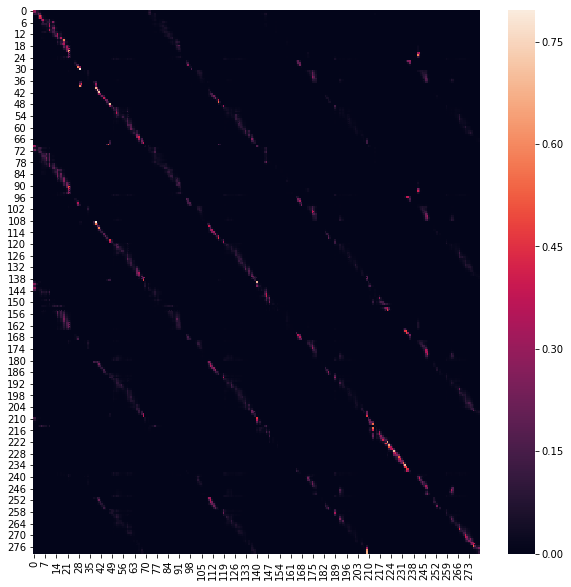

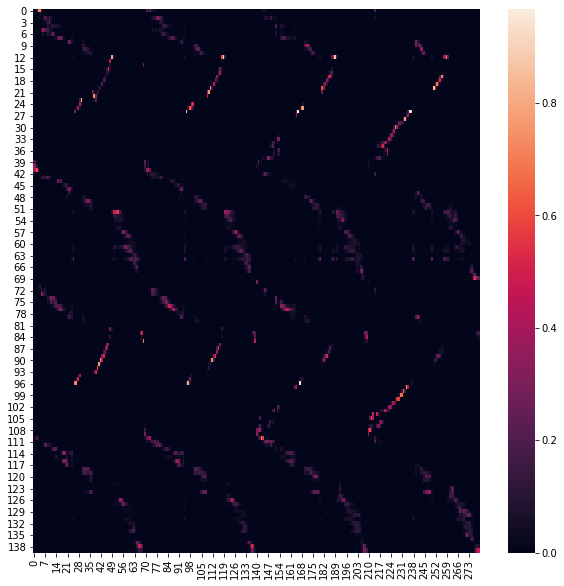

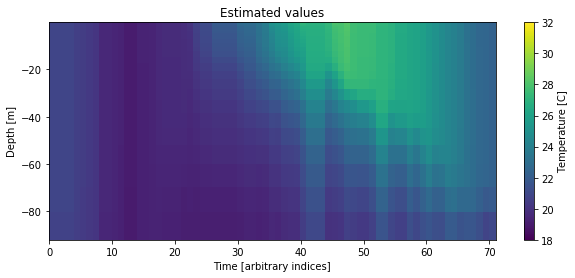

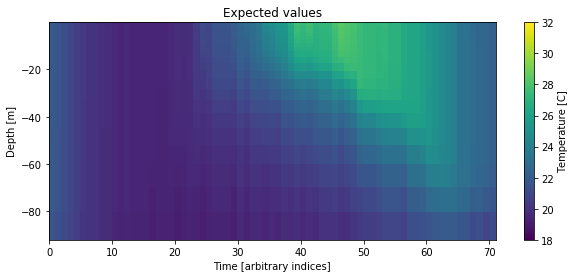

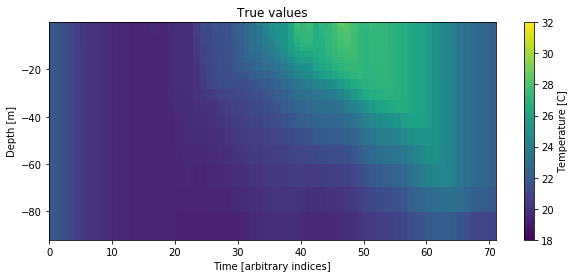

In [55]:
############ STEP 1.2.2 ##################################################

# ----------------------------
# TODO: (optional)
# ---- change the number of iterations 
iterations = 5
# ----------------------------

print(" #################### BAUM-WELCH ##########################")
for i in range(iterations):
    myHMM.bw(np.concatenate([map_obs_train.classes, map_obs_test.classes]))

print(" #################### VISUALIZATION ##########################")
classes_hid_est = myHMM.viterbi(map_obs_test.classes)
map_hid_est = map2d.Map2d(som=map_hid_test.som, name=name_est)
map_hid_est.map_from_classes(classes_hid_est, true_values=map_hid_test.true_values, overwrite=True)

fig= plt.figure(figsize=(10,10))
sns.heatmap(myHMM.Tr, annot=False)
fig= plt.figure(figsize=(10,10))
sns.heatmap(myHMM.Em, annot=False)


print_data(map_hid_est.values,depth,zmin=18,zmax=32, legend="Estimated values", figsize=(10,4))
print_data(map_hid_test.values,depth,zmin=18,zmax=32, legend="Expected values", figsize=(10,4))
print_data(map_hid_est.true_values,depth,zmin=18,zmax=32, legend="True values", figsize=(10,4))


##### 1.2.3 Smooth transitions

Baum-Welch is an expectation-maximization algorithm that only needs as input the observable time-series. If the training dataset is too small this might cause some discontinuity in the hidden time-series reconstructed. 

However, as mentioned in the step 1.2.1, to deal with this kind of problem we can use a neighborhood function that exploits SOM topological properties. Nevertheless, the objective is not to spread the probability of a hidden class to its neighbors but to decrease the probability of transiting from $i$ to $j$ if $i$ and $j$ are far from each other in ``̀som_hid`` 

We use then another method called ``smooth_transitions`` that updates the transition matrix as follows:

$$
Tr(i,j) =S^{-1} exp(-\frac{dist(i,j)}{\sigma}) Tr(i,j) 
$$

with $S_{Tr}^{-1}$ a normalizing factor such as $\sum_{j=1}^{N_{dis}} Tr(i,j) = 1$

- if $\sigma$ too is small, the model will barely transit from one class to another

- if $\sigma$ is too large, the new probabilities will not be almost the same as before

We use here the same radius $\sigma$ as in the other neighbourhood function for the same reasons but once again, feel free to try other radius! 

<span style="background-color: ##FFFF00">**TO DO**: (Optional)</span>
- Change the value of ``sigma`` and observe the results! :) 
- Change the condition of applying the neighborhood function

 #################### SMOOTH_TRANSITIONS ##########################
Viterbi algorithm done in  0.05  sec, using  72  inputs
 #################### VISUALIZATION ##########################
Viterbi algorithm done in  0.05  sec, using  72  inputs


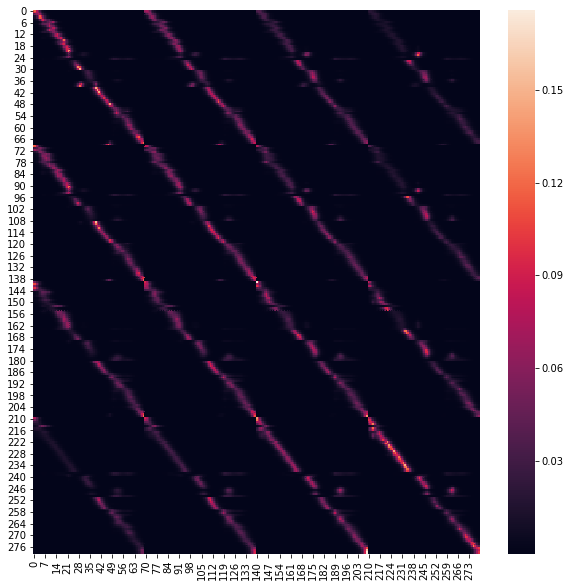

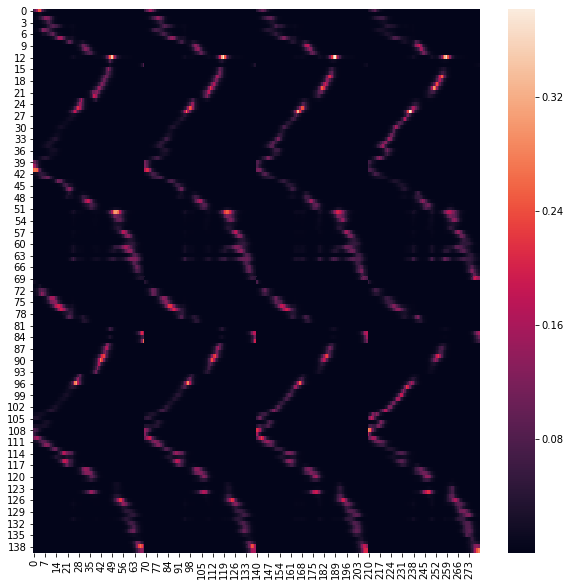

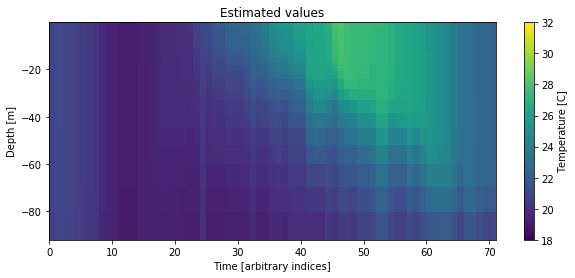

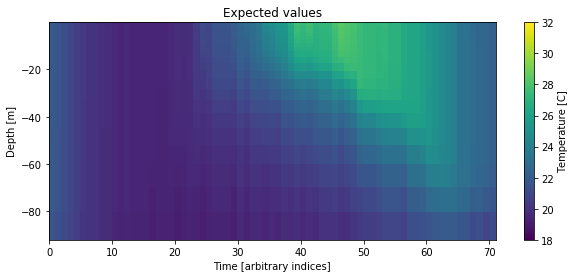

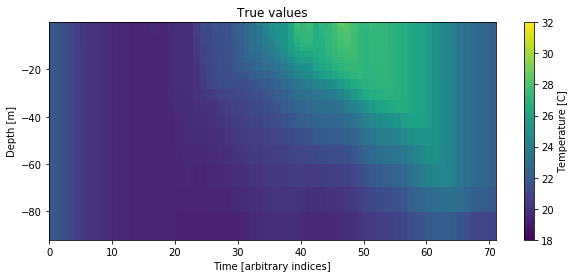

In [56]:
############ STEP 1.2.3 ##################################################

dist_mean = np.mean(map_hid_est.distance_transition)
dist_std = np.std(map_hid_est.distance_transition)
if (dist_mean>dist_ref_mean):
    print(" #################### SMOOTH_TRANSITIONS ##########################")
    dist_matrix = map_hid_est.som.distance_matrix
    myHMM.neighborhood(sigma=dist_ref_mean,
                        distance_matrix=map_hid_train.som.distance_matrix)

    classes_hid_est = myHMM.viterbi(map_obs_test.classes)
    map_hid_est.map_from_classes(classes_hid_est, true_values=map_hid_test.true_values, overwrite=True)
    
print(" #################### VISUALIZATION ##########################")
classes_hid_est = myHMM.viterbi(map_obs_test.classes)
map_hid_est = map2d.Map2d(som=map_hid_test.som, name=name_est)
map_hid_est.map_from_classes(classes_hid_est, true_values=map_hid_test.true_values, overwrite=True)

fig= plt.figure(figsize=(10,10))
sns.heatmap(myHMM.Tr, annot=False)
fig= plt.figure(figsize=(10,10))
sns.heatmap(myHMM.Em, annot=False)


print_data(map_hid_est.values,depth,zmin=18,zmax=32, legend="Estimated values", figsize=(10,4))
print_data(map_hid_test.values,depth,zmin=18,zmax=32, legend="Expected values", figsize=(10,4))
print_data(map_hid_est.true_values,depth,zmin=18,zmax=32, legend="True values", figsize=(10,4))

## STEP 2: HMM results

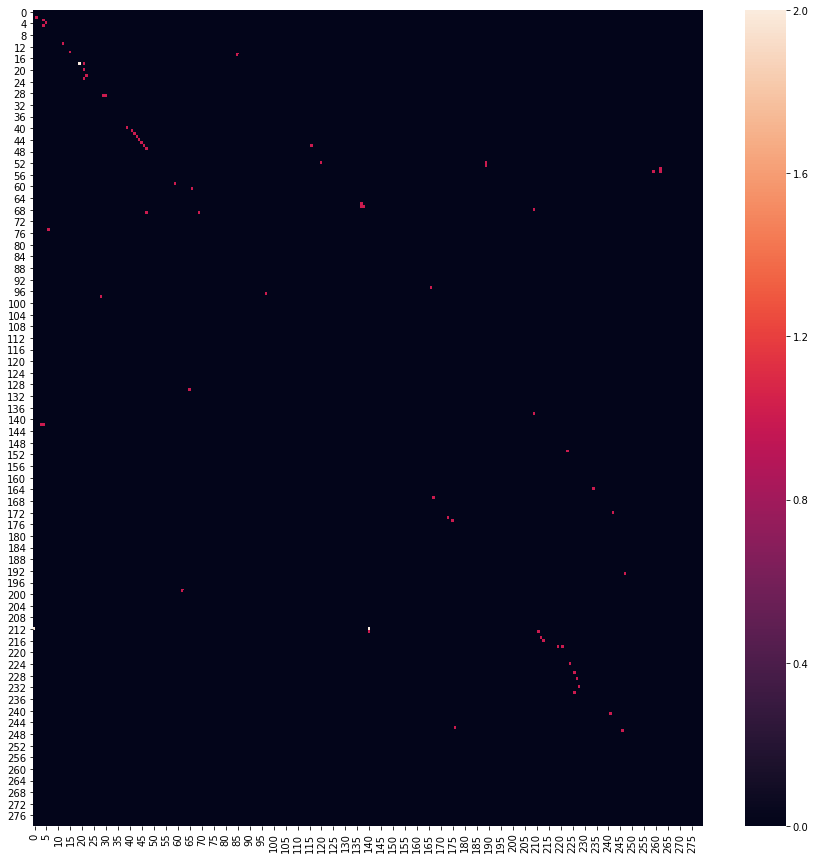

In [57]:
confusion_matrix = map2d.confusion_matrix(map_hid_test, map_hid_est)
fig= plt.figure(figsize=(15,15))
sns.heatmap(confusion_matrix, annot=False)

In [58]:
distance_between_labels = map2d.distance_between_labels(map_hid_test, map_hid_est)
print(distance_between_labels)

[ 8.          4.          2.          1.          0.          2.23606798
  3.          1.          3.          3.          2.          2.23606798
  3.16227766  2.23606798  3.60555128  3.60555128  1.          2.23606798
  2.82842712  1.          1.          1.          1.41421356  1.
  1.          1.          1.          1.          3.          1.
  2.          0.          0.          1.          1.          0.
  1.          1.         16.03121954  4.24264069  3.60555128  6.70820393
  4.47213595  3.60555128  2.23606798  0.          3.60555128  5.09901951
  5.          1.41421356  1.          1.41421356  2.23606798  1.41421356
  0.         22.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          1.
  0.          1.          0.          0.          1.41421356  1.        ]


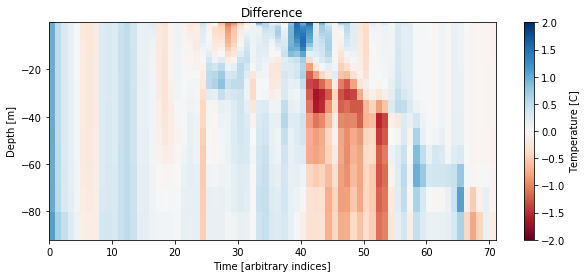

In [59]:
difference = map_hid_est.true_values - map_hid_est.values

print_data(difference,depth,zmin=-2,zmax=2, legend="Difference", figsize=(10,4), cmap='RdBu')

**If you are satisfied with the results you can save your Hmm and Map2d objects! :)**

In [ ]:
map2d.save(map_hid_est, path=path_map_est)
hmm.save(myHMM, path=path_hmm)